In [15]:
import numpy as np, pandas as pd
from pathlib import Path

# -------------------------
# CONFIG / HELPERS
# -------------------------
DZGROUP_PREFIX = "dzgroup_"
DZCLASS_PREFIX = "dzclass_"

# thresholds for proposing a "child set" of dzgroup_* that define a dzclass_*
PHI_MIN = 0.15           # correlation threshold
P_GIVEN_CLASS_MIN = 0.05 # % of class covered by a given group to consider it relevant

def _b(s: pd.Series) -> pd.Series:
    """binary 0/1 from Int64/float/bool with NA-safe handling"""
    return s.fillna(0).astype(int)

def find_cols(df, prefix):
    return [c for c in df.columns if c.startswith(prefix)]

def phi_corr(x, y):
    x = _b(x); y = _b(y)
    if x.nunique() < 2 or y.nunique() < 2:
        return np.nan
    return x.corr(y)

# -------------------------
# 0) SELECT COLUMNS
# -------------------------

df = pd.read_csv('/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/01_processed/support_preprocessed_clean.csv')
dzg = find_cols(df, DZGROUP_PREFIX)
dzc = find_cols(df, DZCLASS_PREFIX)

print(f"Found {len(dzc)} dzclass_* and {len(dzg)} dzgroup_* columns.")

# -------------------------
# 1) PREVALENCE SNAPSHOT
# -------------------------
prev = df[dzg + dzc].apply(lambda s: _b(s).mean()).sort_values(ascending=False)
display(prev.to_frame("prevalence").round(3))

# -------------------------
# 2) FULL OVERLAP TABLES FOR EACH dzclass_*
#    - For each umbrella (dzclass_*), compute per-dzgroup stats:
#      TP, P(group|class), P(class|group), Jaccard, phi
# -------------------------
def overlap_table_for_class(df, class_col, group_cols):
    x = _b(df[class_col])
    p1 = x.sum()
    rows = []
    for g in group_cols:
        y = _b(df[g])
        tp = ((x == 1) & (y == 1)).sum()
        p2 = y.sum()
        p_g_given_c = tp / p1 if p1 else np.nan         # coverage of class by this group
        p_c_given_g = tp / p2 if p2 else np.nan         # purity of group relative to class
        jacc = tp / (p1 + p2 - tp) if (p1 + p2 - tp) else np.nan
        rows.append({
            "dzclass": class_col,
            "dzgroup": g,
            "tp": int(tp),
            "P(group|class)": p_g_given_c,
            "P(class|group)": p_c_given_g,
            "jaccard": jacc,
            "phi": phi_corr(x, y),
            "class_n": int(p1),
            "group_n": int(p2),
        })
    out = pd.DataFrame(rows).sort_values(["phi", "P(group|class)", "jaccard"], ascending=False)
    return out

# Example: inspect one umbrella quickly (edit the name to explore)
# display(overlap_table_for_class(df, "dzclass_cancer", dzg).head(15))

# -------------------------
# 3) UNION-OF-CHILDREN REDUNDANCY TEST
#    - For each dzclass_*, pick candidate child dzgroup_* by (phi >= PHI_MIN OR P(group|class) >= P_GIVEN_CLASS_MIN)
#    - Build the OR/union of those groups and compare to the umbrella
# -------------------------
def union_test_for_class(df, class_col, group_cols, phi_min=PHI_MIN, pgc_min=P_GIVEN_CLASS_MIN):
    tab = overlap_table_for_class(df, class_col, group_cols)
    candidates = tab[(tab["phi"] >= phi_min) | (tab["P(group|class)"] >= pgc_min)]["dzgroup"].tolist()
    x = _b(df[class_col])
    if candidates:
        U = _b(df[candidates]).max(axis=1)  # OR across child groups
    else:
        U = pd.Series(0, index=df.index)
    tp = ((x==1) & (U==1)).sum()
    fn = ((x==1) & (U==0)).sum()
    fp = ((x==0) & (U==1)).sum()
    tn = ((x==0) & (U==0)).sum()
    cover = tp / x.sum() if x.sum() else np.nan  # how much of class is explained by union
    purity = tp / U.sum() if U.sum() else np.nan # how pure the union is for the class
    jacc = tp / (x.sum() + U.sum() - tp) if (x.sum() + U.sum() - tp) else np.nan
    phi_u = phi_corr(x, U)
    return {
        "dzclass": class_col,
        "n_candidates": len(candidates),
        "candidate_groups": candidates,
        "class_n": int(x.sum()),
        "union_n": int(U.sum()),
        "tp": int(tp), "fn": int(fn), "fp": int(fp), "tn": int(tn),
        "coverage = P(U|class)": cover,
        "purity = P(class|U)": purity,
        "jaccard(class, U)": jacc,
        "phi(class, U)": phi_u,
    }

union_summaries = pd.DataFrame([union_test_for_class(df, c, dzg) for c in dzc]) \
                    .sort_values(["coverage = P(U|class)", "phi(class, U)"], ascending=False)

display(union_summaries[["dzclass","n_candidates","class_n","union_n",
                         "coverage = P(U|class)","purity = P(class|U)",
                         "jaccard(class, U)","phi(class, U)"]].round(3))

# -------------------------
# 4) FLAGS FOR ENGINEERING DECISIONS
#    - Likely redundant umbrellas: very high coverage + high phi with union
#    - Good residual candidates: moderate/low coverage (class has extra positives not explained by groups)
# -------------------------
REDUNDANT = (union_summaries["coverage = P(U|class)"] >= 0.98) & (union_summaries["phi(class, U)"] >= 0.9)
RESIDUAL  = (union_summaries["coverage = P(U|class)"] >= 0.50) & (union_summaries["coverage = P(U|class)"] < 0.98)

print("\n>>> Umbrellas that look like PURE unions of dzgroup_* (drop after unioning):")
display(union_summaries.loc[REDUNDANT, ["dzclass","n_candidates","candidate_groups",
                                        "coverage = P(U|class)","purity = P(class|U)"]])

print("\n>>> Umbrellas with meaningful 'leftover' signal (keep as residual):")
display(union_summaries.loc[RESIDUAL, ["dzclass","n_candidates","candidate_groups",
                                       "coverage = P(U|class)","purity = P(class|U)"]])

# -------------------------
# 5) QUICK PER-UMBRELLA DETAIL DRILLDOWN
#    - For each umbrella, show the top dzgroup drivers
# -------------------------
def top_groups_for_each_class(df, dzc, dzg, topn=8):
    frames = []
    for c in dzc:
        tab = overlap_table_for_class(df, c, dzg).head(topn)
        frames.append(tab.assign(rank=np.arange(1, len(tab)+1)))
    return pd.concat(frames, ignore_index=True)

top8 = top_groups_for_each_class(df, dzc, dzg, topn=8)
display(top8.style.format({"P(group|class)":"{:.3f}", "P(class|group)":"{:.3f}", "jaccard":"{:.3f}", "phi":"{:.3f}"}))

# -------------------------
# 6) RESIDUAL PREVIEW (non-destructive)
#    For each dzclass_*, build a residual flag = class AND NOT (union of its candidate groups).
#    This shows how many 1s would remain if we "explain away" the class by its child groups.
# -------------------------
def residual_preview(df, dzc, dzg):
    out = {}
    for c in dzc:
        cand = [r["candidate_groups"] for _, r in union_summaries[union_summaries["dzclass"]==c].iterrows()]
        cand = cand[0] if cand else []
        x = _b(df[c])
        U = _b(df[cand]).max(axis=1) if cand else pd.Series(0, index=df.index)
        resid = ((x==1) & (U==0)).astype(int)
        out[c.replace(DZCLASS_PREFIX, DZCLASS_PREFIX+"resid_")] = resid.astype("Int64")
    return pd.DataFrame(out, index=df.index)

resid_demo = residual_preview(df, dzc, dzg)
print("\nResidual preview columns (NOT added to df yet):", list(resid_demo.columns)[:6], " ...")
display(resid_demo.sum().sort_values(ascending=False).to_frame("residual_ones"))

# (Optional) to join and inspect:
# df_preview = pd.concat([df[dzc + dzg], resid_demo], axis=1)
# display(df_preview.sample(5))


Found 4 dzclass_* and 8 dzgroup_* columns.


,prevalence
dzclass_arf_mosf,0.464
dzgroup_arf_mosf,0.386
dzclass_copd_chf_cirrhosis,0.314
dzclass_cancer,0.156
dzgroup_chf,0.152
dzgroup_copd,0.106
dzgroup_lung_cancer,0.100
dzgroup_mosf_malig,0.078
dzgroup_coma,0.065
dzclass_coma,0.065


,dzclass,n_candidates,class_n,union_n,coverage = P(U|class),purity = P(class|U),"jaccard(class, U)","phi(class, U)"
0,dzclass_arf_mosf,2,4227,4227,1.0,1.0,1.0,1.0
1,dzclass_copd_chf_cirrhosis,3,2862,2862,1.0,1.0,1.0,1.0
2,dzclass_cancer,2,1420,1420,1.0,1.0,1.0,1.0
3,dzclass_coma,1,596,596,1.0,1.0,1.0,1.0



>>> Umbrellas that look like PURE unions of dzgroup_* (drop after unioning):


,dzclass,n_candidates,candidate_groups,coverage = P(U|class),purity = P(class|U)
0,dzclass_arf_mosf,2,"[dzgroup_arf_mosf, dzgroup_mosf_malig]",1.0,1.0
1,dzclass_copd_chf_cirrhosis,3,"[dzgroup_chf, dzgroup_copd, dzgroup_cirrhosis]",1.0,1.0
2,dzclass_cancer,2,"[dzgroup_lung_cancer, dzgroup_colon_cancer]",1.0,1.0
3,dzclass_coma,1,[dzgroup_coma],1.0,1.0



>>> Umbrellas with meaningful 'leftover' signal (keep as residual):


,dzclass,n_candidates,candidate_groups,coverage = P(U|class),purity = P(class|U)


,dzclass,dzgroup,tp,P(group|class),P(class|group),jaccard,phi,class_n,group_n,rank
0,dzclass_arf_mosf,dzgroup_arf_mosf,3515,0.832,1.000,0.832,0.852,4227,3515,1
1,dzclass_arf_mosf,dzgroup_mosf_malig,712,0.168,1.000,0.168,0.313,4227,712,2
2,dzclass_arf_mosf,dzgroup_cirrhosis,0,0.000,0.000,0.000,-0.226,4227,508,3
3,dzclass_arf_mosf,dzgroup_colon_cancer,0,0.000,0.000,0.000,-0.227,4227,512,4
4,dzclass_arf_mosf,dzgroup_coma,0,0.000,0.000,0.000,-0.246,4227,596,5
5,dzclass_arf_mosf,dzgroup_lung_cancer,0,0.000,0.000,0.000,-0.310,4227,908,6
6,dzclass_arf_mosf,dzgroup_copd,0,0.000,0.000,0.000,-0.321,4227,967,7
7,dzclass_arf_mosf,dzgroup_chf,0,0.000,0.000,0.000,-0.395,4227,1387,8
8,dzclass_copd_chf_cirrhosis,dzgroup_chf,1387,0.485,1.000,0.485,0.626,2862,1387,1
9,dzclass_copd_chf_cirrhosis,dzgroup_copd,967,0.338,1.000,0.338,0.509,2862,967,2



Residual preview columns (NOT added to df yet): ['dzclass_resid_arf_mosf', 'dzclass_resid_copd_chf_cirrhosis', 'dzclass_resid_cancer', 'dzclass_resid_coma']  ...


,residual_ones
dzclass_resid_arf_mosf,0
dzclass_resid_copd_chf_cirrhosis,0
dzclass_resid_cancer,0
dzclass_resid_coma,0


In [31]:
from sklearn.decomposition import PCA

pview = pd.read_csv('/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/01_processed/P_view_scaled.csv')

Xs = pview.loc[:, pview.columns != 'eid.1'].copy()

# PCA: retain ≈80% variance
pca = PCA(n_components=0.80, svd_solver="full")
Z   = pca.fit_transform(Xs)
print(f"[PCA]: components={Z.shape[1]} (≈80% var)")


[PCA]: components=1 (≈80% var)


In [33]:

df1 = pd.read_csv("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/02_clusters/mmsp_clusters.csv")
print(df1['stratum'].value_counts())


stratum
Low_MM     4183
Mid_MM     3822
High_MM    1100
Name: count, dtype: int64


In [3]:
import json
from pathlib import Path

rules = json.loads(Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/surrogate_high/tables/tree_rules.json").read_text())
glossary = json.loads(Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/glossary.json").read_text())

features_in_rules = set(rules["feature_names"])
glossary_keys = set(glossary.keys())

missing = sorted(features_in_rules - glossary_keys)
extra   = sorted(glossary_keys - features_in_rules)

print("Missing glossary entries:", missing)
print("Glossary entries not used by this tree:", extra[:20], "..." if len(extra) > 20 else "")

if missing:
    raise SystemExit(
        f"Glossary mismatch: {len(missing)} feature(s) used by tree have no glossary entry. "
        f"Add or auto-generate them before LLM translation."
    )

rules_path = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/surrogate_high/tables/tree_rules.json")
gloss_path = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/glossary.json")
out_path   = Path("/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/glossary_used.json")

rules = json.loads(rules_path.read_text())
gloss = json.loads(gloss_path.read_text())

feature_names = set(rules["feature_names"])
# Always carry optional metadata block if present
subset = {"_meta": gloss.get("_meta", {})}
subset.update({k: v for k, v in gloss.items() if k in feature_names})

out_path.write_text(json.dumps(subset, indent=2))
print(f"Wrote trimmed glossary with {len(subset)-('_meta' in subset)} features -> {out_path}")


Missing glossary entries: []
Glossary entries not used by this tree: ['_meta', 'd.time', 'death', 'dnrday', 'dzclass_arf_mosf', 'dzclass_cancer', 'dzclass_coma', 'dzclass_copd_chf_cirrhosis', 'eid', 'hday', 'hospdead', 'id', 'prg6m', 'sfdm2', 'slos', 'surv6m', 'totmcst'] 
Wrote trimmed glossary with 43 features -> /Users/harisreedeth/Desktop/D/personal/ProjectMAIP/reports/glossary_used.json


['dzgroup_arf_mosf', 'dzgroup_chf', 'dzgroup_copd', 'dzgroup_lung_cancer', 'dzgroup_mosf_malig', 'dzgroup_coma', 'dzgroup_cirrhosis', 'dzgroup_colon_cancer']
              Condition  Count
0      dzgroup_arf_mosf   3515
1           dzgroup_chf   1387
2          dzgroup_copd    967
3   dzgroup_lung_cancer    908
4    dzgroup_mosf_malig    712
5          dzgroup_coma    596
6  dzgroup_colon_cancer    512
7     dzgroup_cirrhosis    508


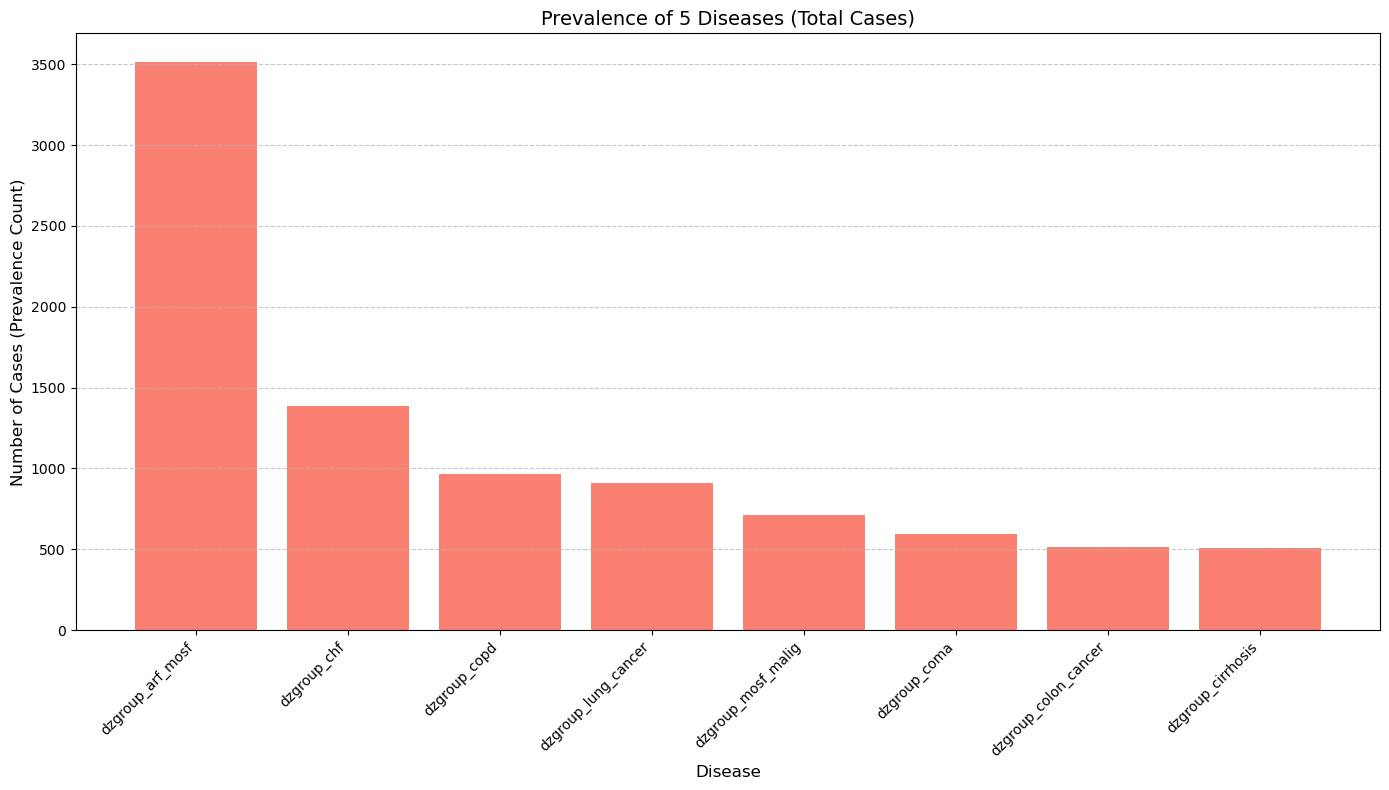

In [ ]:
# Prevalence. Important for survival modelling.
import numpy as np, pandas as pd
import matplotlib.pyplot as plt

df = pd.read_csv('/Users/harisreedeth/Desktop/D/personal/ProjectMAIP/data/01_processed/support_preprocessed_clean.csv')
startstring = "dzgroup"
dzgroups = [c for c in df.columns if c.startswith(startstring)]
print(dzgroups)

# prev dataframe
prev = df[dzgroups].sum().sort_values(ascending=False)
prevdf = prev.reset_index()
prevdf.columns = ['Condition', 'Count']
print(prevdf)

# plot.
plt.figure(figsize=(14,8))
plt.bar(prevdf['Condition'], prevdf['Count'], color = 'salmon')
plt.xlabel('Condition', fontsize=12)
plt.ylabel('Number of Condition (Prevalence Count)', fontsize=12)
plt.title('Prevalence of 5 Condition (Total Cases)', fontsize=14)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
